# **一、数据生成，并保存到文件中**

- **读取数据，并设置一些必要参数**
- `image` **影像**
- `label` **标签**

In [1]:
from skimage import io
import random
import numpy as np
image = "./original_image/rgb/rgb.tif"
label = "./original_image/label/label.tif"
imagery = io.imread(image)
label = io.imread(label)

In [3]:
import warnings
warnings.filterwarnings('ignore')
imageSize = 256
number = 30000
height = imagery.shape[0]
width = imagery.shape[1]
tree_rate = -1
index = 0
while True:
    UpperLeftX = random.randint(0, height - imageSize)
    UpperLeftY = random.randint(0, width - imageSize)
    labelCrop = label[(UpperLeftX): (UpperLeftX + imageSize), (UpperLeftY): (UpperLeftY + imageSize)]
    labelCrop[labelCrop > 1] = 1
    tree_rate = np.count_nonzero(labelCrop > 0) / (labelCrop.size)
    if((tree_rate > 0.01)):
        # 符合要求，保存图像
        imgCrop = imagery[UpperLeftX: UpperLeftX + imageSize, UpperLeftY: UpperLeftY + imageSize, 0:3]
        io.imsave("./Sample/rgb/"+str(index)+".tif", imgCrop)
        io.imsave("./Sample/label/"+str(index)+".tif", labelCrop)
        if(index == number):
            break
        index += 1

# **二、定义torch数据生成器**

1. **获取标签和图片对应的路径**   
2. **`getitem`函数**

In [4]:
# 训练图像分割的生成器
from torch.utils.data import Dataset
import torchvision
import torch
from skimage import io
import os
totensor = torchvision.transforms.ToTensor()
#  imageDataRoot路径应该直接指向一张完整的tif影像
#  labelDataRoot路径应该直接指向一张完整的tif标签

class SegImageDataset(Dataset):
    def __init__(self, imageDataRoot,labelDataRoot):
        self.img_paths_folder = imageDataRoot
        self.label_paths_folder = labelDataRoot

        self.img_paths = [] # 图像文件的路径
        self.label_paths = [] # 图像对应的标签

        self.folders =  os.listdir(self.img_paths_folder)
        for folder in self.folders:
            self.img_paths.append(os.path.join(self.img_paths_folder, folder))
            self.label_paths.append(os.path.join(self.label_paths_folder, folder))


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,index):
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        img = io.imread(img_path)
        label = io.imread(label_path)
        label = label.reshape(1,label.shape[0],label.shape[1])
        # 转图片格式
        img = totensor(img)
        label = torch.Tensor(label)
        return (img,label)

In [5]:
from torchvision import transforms as transforms
import random
def augment(images,labels):
    # 水平翻转
    if random.random() > 0.5:
        images = transforms.RandomHorizontalFlip(p=1)(images)
        labels = transforms.RandomHorizontalFlip(p=1)(labels)
    # 垂直翻转
    if random.random() > 0.5:
        images = transforms.RandomVerticalFlip(p=1)(images)
        labels = transforms.RandomVerticalFlip(p=1)(labels)
#     # 灰度变换
#     if random.random() > 0.75:
#         images = transforms.Grayscale()(images)
    # 随机旋转
    if random.random() > 0.3:
        degrees = random.randint(0,360)
        images = transforms.RandomRotation([degrees,degrees])(images)
        labels = transforms.RandomRotation([degrees,degrees])(labels)
    # 高斯模糊
    if random.random() > 0.5:
        images = transforms.GaussianBlur(kernel_size=(3, 3), sigma=random.randint(3,7))(images)
    # 亮度、对比度和饱和度调节
    # if random.random() > 0.5:
    #     random1 = random.randint(50,100)/100
    #     random2 = random.randint(50,100)/100
    #     random3 = random.randint(50,100)/100
    #     images = transforms.ColorJitter(brightness=random1, contrast=random2, saturation=random3)(images)
    return (images,labels)

- **`samplePath` 样本rgb的路径**
- **`labelPath` 标签的路径**

torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256])


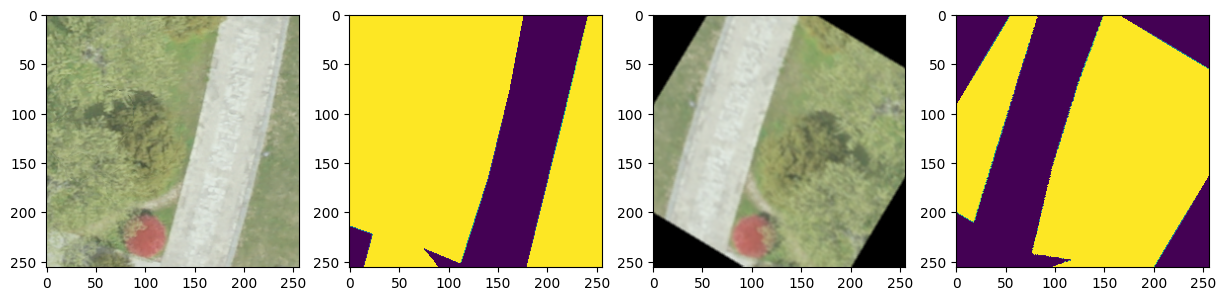

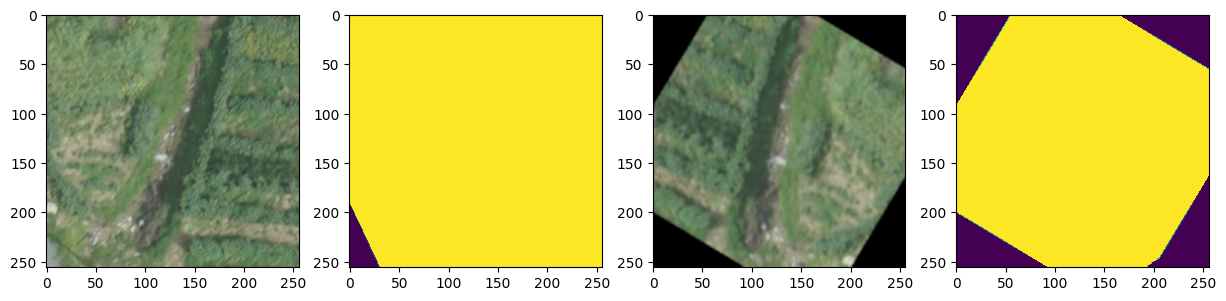

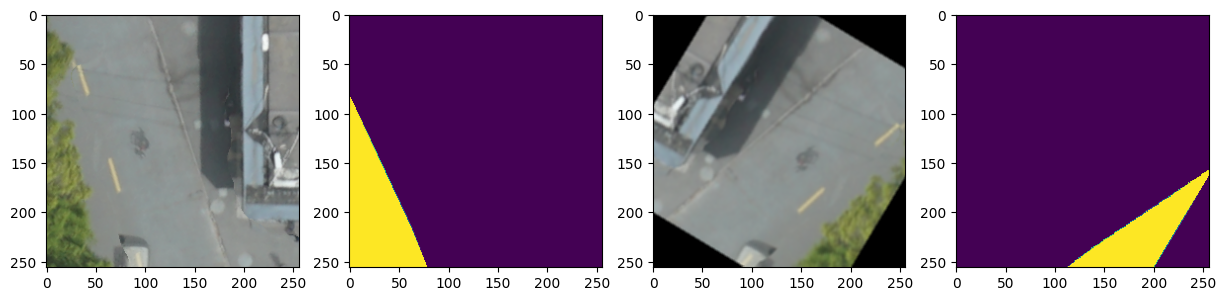

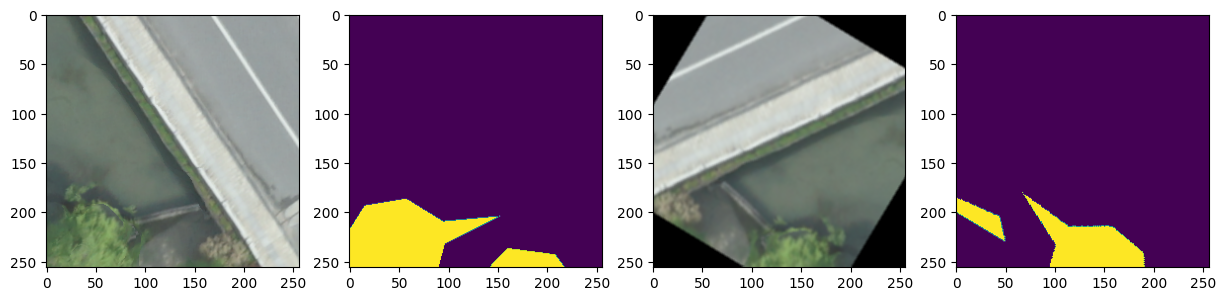

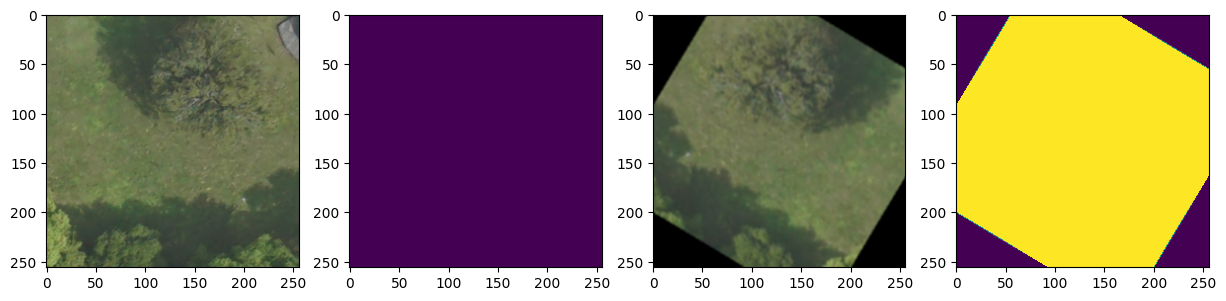

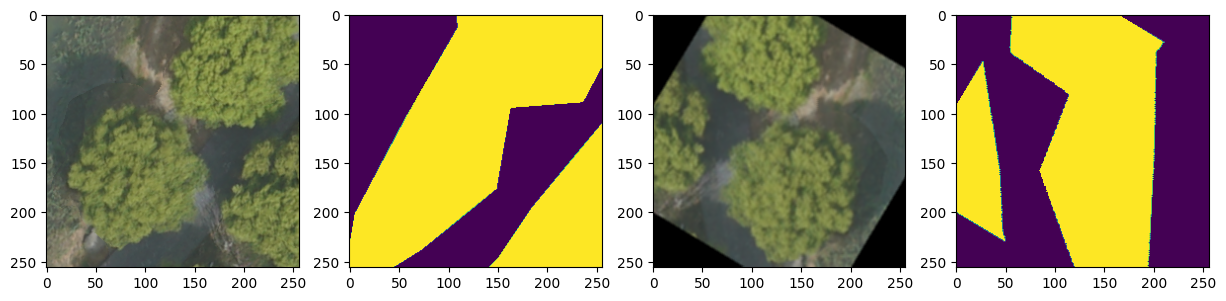

In [6]:
# 路径中一定不成出现中文，否则tif文件打不开
samplePath = "./Sample/rgb/"
labelPath = "./Sample/label/"
ImageDataset =  SegImageDataset(samplePath, labelPath)
import numpy as np
import matplotlib.pyplot as plt
train_loader = torch.utils.data.DataLoader(
        ImageDataset,
        batch_size=6,
        shuffle=True,
        pin_memory=True)
for i, (images, labels) in enumerate(train_loader):
    if i == 1:
        break
    new_images,new_labels = augment(images,labels)
    print(images.shape,labels.shape)
    for index in range(images.shape[0]):
        plt.figure(figsize=(15,15))
        plt.subplot(1, 4, 1)
        plt.imshow(np.transpose(images[index], (1,2,0)))# 把channel那一维放到最后
        plt.subplot(1, 4, 2)
        plt.imshow(np.transpose(labels[index], (1,2,0)))# 把channel那一维放到最后
        plt.subplot(1, 4, 3)
        plt.imshow(np.transpose(new_images[index], (1,2,0)))# 把channel那一维放到最后
        plt.subplot(1, 4, 4)
        plt.imshow(np.transpose(new_labels[index], (1,2,0)))# 把channel那一维放到最后
    plt.show()
